# Preparation: cleaned, selected, expended

## Duplicates

In [60]:
import config
import os
import datetime
import random
import pandas as pd
import dask
import dask.dataframe as dd

import math
import geopandas as gpd
from shapely.geometry import Polygon
import scienceplots
import matplotlib.pyplot as plt
plt.style.use(['science'])


def gps_to_grid(lat, lon):
    """ Calculate grid index for a given GPS coordinate """
    lat_index = int((lat - (min_lat - delta_lat / 2)) / delta_lat)
    lon_index = int((lon - (min_lon - delta_lon / 2)) / delta_lon)
    return lat_index, lon_index

def grid_to_gps(lat_index, lon_index):
    """ Calculate GPS coordinates of the center point for a given grid index """
    lat = lat_index * delta_lat + min_lat
    lon = lon_index * delta_lon + min_lon
    return lat, lon

def unix_to_datetime(timestamp: str) -> datetime:
    """
    convert unix to datetime
    >>> dt = unix_to_datetime('1538402919')
    >>> print(dt.strftime('%Y/%m/%d %H:%M:%S'))
    2018/10/01 22:08:39
    """
    return datetime.datetime.fromtimestamp(int(timestamp))

dataset = config.chengdu_dataset
parquet = os.path.join(dataset, 'cleaned')
shp = os.path.join(dataset, 'grid')
filepaths = [os.path.join(dataset, i) 
                 for i in os.listdir(dataset) 
                 if i.startswith('chengdu') and i.endswith('.csv')]

ddf = dd.read_csv(filepaths, header=None, names=['oid', 'wid', 'traj'], blocksize=64e6)
ddf.head()

,oid,wid,traj
0,92a1d44607c036fbc9db971258c0e013,f5e36c97e4a8052a2aa9c7f8ed0f969a,"[104.04538 30.70745 1538402919, 104.04538 30.7..."
1,0e95f18113ad01cf626289344fd39f4e,c5f1bba8b2cfad357a9ed65dc3021ff1,"[104.08169 30.6705 1538406898, 104.08169 30.67..."
2,7dceae818438b836e3d306296b4ccfbd,0e3f29616d126177f5db9bfb27be21de,"[104.04235 30.69204 1538334938, 104.04268 30.6..."
3,94bba68a63c866769c1c3b37834518fa,c480964f535eede621a1ac4dde7073a6,"[104.04714 30.7263 1538345323, 104.04698 30.72..."
4,8601cc60cfea2fc7f599ebf9b2a4d977,5f3cabc6ff9083e6c79f3f798a9c17e2,"[104.11542 30.65289 1538322576, 104.11574 30.6..."


In [5]:
oid_counts = ddf['oid'].value_counts().compute()
oid_counts

oid
9b03ba4b883589437f576e6d45435975    3
6d5b3df29e64e92707f8dd3f47b15471    3
f415b32132dd4c955b98c27fe35824e7    3
142595ef9cbdb1b884d41e77ac0ec13c    3
f1c2fe4e339795703de6881e9c2321c1    3
                                   ..
589eb618d04cb8073603eb1de3f9f09c    1
589eb7568d4f1010852190faba0cd8a6    1
589eb8f2c67472b87c7d897e36fcb25b    1
589eb9f86395b909af4d48186c8f81f1    1
ffffff8833834f30c11a16f92c1284a0    1
Name: count, Length: 14458396, dtype: int64

In [6]:
duplicate_orders = (oid_counts[oid_counts > 1]).index.tolist()
duplicate_orders

['9b03ba4b883589437f576e6d45435975',
 '6d5b3df29e64e92707f8dd3f47b15471',
 'f415b32132dd4c955b98c27fe35824e7',
 '142595ef9cbdb1b884d41e77ac0ec13c',
 'f1c2fe4e339795703de6881e9c2321c1',
 '3641082460d302ef26a756dfb33a8549',
 '76ae6ac11442a34d25d8b8a686d6213c',
 '53a8bbe21fe7f7b470ecee3ead836abe',
 'd88f8bb8e2c6d50258aadbf4134d4334',
 '5d27b0ece83e94674b00fcbb73a3e6d5',
 'df993103ea6f64dc0d5b071c1022dabb',
 '0ce176b6d65d5c146c731a6137665460',
 '7fe318f804cc5992f4508b915d3547ac',
 'f4159e974ed35a4e1d808951f2afa16a',
 '71bcd49890bace59759c91595fe304b5',
 '19633b1ab1f2dd85e520c2ff9c69824f',
 'c6e3294e33105c45c16d19c596c33ad4',
 'a0aa5bb5a67020189045101cb0264305',
 'a943f2ccb9d75b876c6f29d7a33f7867',
 '84af055b5408b8611b56529e799d50e3',
 '53a8c8720ed8eacf98f8c5e0c7b79b6b',
 '3715da57c283df6c32e8e8a0882ffb8b',
 '3d9fe5087ed75f922279d5300e36f1b4',
 'e8e516942b49c3e041f54f99bdd260ec',
 'dbd57fb4646a1994208c68fefd78d6a2',
 '492dcbcf4e8937b6a9b7b6d946b75e2c',
 'c3fb2c66c72dd75d791ae6cb8d59e475',
 

In [52]:
if not os.path.exists(parquet) or len(os.listdir(parquet)) == 0:
    os.makedirs(parquet, exist_ok=True)
    ddf = dd.read_csv(filepaths, header=None, names=['oid', 'wid', 'traj'])
    ddf[~ddf['oid'].isin(duplicate_orders)].to_parquet(parquet)

parquet_files = [os.path.join(parquet, i) 
                 for i in os.listdir(parquet) 
                 if i.startswith('part') and i.endswith('.parquet')]
ddf = dd.read_parquet(parquet_files)
ddf.head()

,oid,wid,traj
0,92a1d44607c036fbc9db971258c0e013,f5e36c97e4a8052a2aa9c7f8ed0f969a,"[104.04538 30.70745 1538402919, 104.04538 30.7..."
1,0e95f18113ad01cf626289344fd39f4e,c5f1bba8b2cfad357a9ed65dc3021ff1,"[104.08169 30.6705 1538406898, 104.08169 30.67..."
2,7dceae818438b836e3d306296b4ccfbd,0e3f29616d126177f5db9bfb27be21de,"[104.04235 30.69204 1538334938, 104.04268 30.6..."
3,94bba68a63c866769c1c3b37834518fa,c480964f535eede621a1ac4dde7073a6,"[104.04714 30.7263 1538345323, 104.04698 30.72..."
4,8601cc60cfea2fc7f599ebf9b2a4d977,5f3cabc6ff9083e6c79f3f798a9c17e2,"[104.11542 30.65289 1538322576, 104.11574 30.6..."


In [13]:
shape, n_wid, wid_counts = dd.compute(ddf.shape, ddf['wid'].nunique(), ddf['wid'].value_counts())

In [14]:
shape

(13394100, 3)

In [19]:
n_wid * 0.95

135640.05

In [45]:
workers = wid_counts[wid_counts > 30].index.tolist() 
len(workers)

85017

In [43]:
wid_counts[wid_counts > 30].to_csv(os.path.join(dataset, 'workers.txt'))

In [55]:
os.path.join(dataset, 'workers.txt')

'/Volumes/WD_BLACK/dataset/chengdu/workers.txt'

In [47]:
workers = pd.read_csv(os.path.join(dataset, 'workers.txt'))
workers

,wid,count
0,248e83a8ef8b7af1815873f9d488fb2b,769
1,9158ae4e303282353602a08135ca505e,737
2,eefefbc7788b7c934c97a19a52845228,718
3,92152394842cba2d5d19f12ebf22d44f,718
4,ad23645b75259f69658a11a1de55abb0,679
...,...,...
85012,e48d949a7a90f17d06fb73c99cde9fd7,31
85013,2b11d43ba53434c69dfb1ee8d7cffe27,31
85014,1521f29cf5a547d3ef622a0d1776a2ab,31
85015,7ed98cdc1851b653be6ecbe14d3b58b3,31


In [101]:
selected = os.path.join(dataset, 'selected')

if not os.path.exists(selected) or len(os.listdir(selected)) == 0:
    os.makedirs(selected, exist_ok=True)
    ddf = dd.read_parquet(parquet_files)
    ddf[ddf['wid'].isin(workers['wid'])].to_parquet(selected)

selected_files = [os.path.join(selected, i) 
                 for i in os.listdir(selected) 
                 if i.startswith('part') and i.endswith('.parquet')]

ddf = dd.read_parquet(selected_files)
ddf.head()

,oid,wid,traj
1,0e95f18113ad01cf626289344fd39f4e,c5f1bba8b2cfad357a9ed65dc3021ff1,"[104.08169 30.6705 1538406898, 104.08169 30.67..."
2,7dceae818438b836e3d306296b4ccfbd,0e3f29616d126177f5db9bfb27be21de,"[104.04235 30.69204 1538334938, 104.04268 30.6..."
3,94bba68a63c866769c1c3b37834518fa,c480964f535eede621a1ac4dde7073a6,"[104.04714 30.7263 1538345323, 104.04698 30.72..."
4,8601cc60cfea2fc7f599ebf9b2a4d977,5f3cabc6ff9083e6c79f3f798a9c17e2,"[104.11542 30.65289 1538322576, 104.11574 30.6..."
5,bc4ed5a4efc9d75add3b4767efe5aabf,c6cad4068fb04e30cda89c75673ee363,"[104.07026 30.72456 1538322724, 104.07011 30.7..."


## Grids

<Axes: >

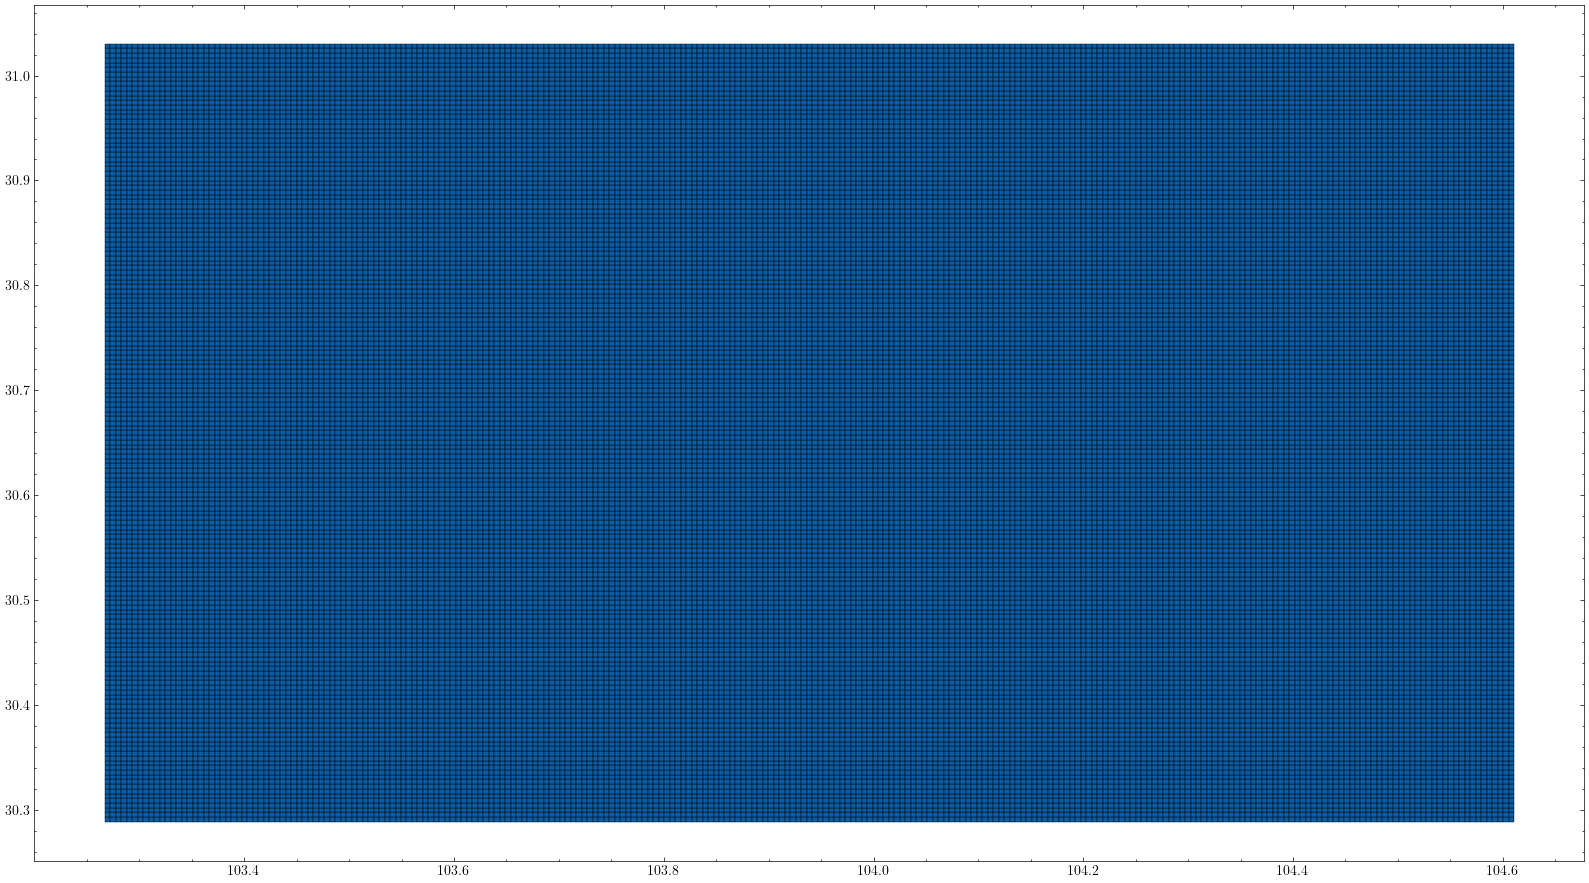

In [62]:
min_lat, max_lat, min_lon, max_lon = (30.29066, 31.032437, 103.269824, 104.609676)
grid_size = config.grid_accuracy
earth_radius = config.earth_radius

# calculate latitude and longitude increments
delta_lat = grid_size * 360 / (2 * math.pi * earth_radius)
delta_lon = grid_size * 360 / (2 * math.pi * earth_radius * math.cos((min_lat + max_lat) * math.pi / 360))

# Create a list to hold grid data
grid_data_list = []

# Calculate the number of grids to generate
num_lon_grids = int((max_lon - min_lon) / delta_lon) + 1
num_lat_grids = int((max_lat - min_lat) / delta_lat) + 1

# Generate grids and populate the dataframe
for i in range(num_lon_grids):
    center_lon = i * delta_lon + min_lon
    for j in range(num_lat_grids):
        center_lat = j * delta_lat + min_lat

        grid_polygon = Polygon([
            (center_lon - delta_lon / 2, center_lat - delta_lat / 2),
            (center_lon + delta_lon / 2, center_lat - delta_lat / 2),
            (center_lon + delta_lon / 2, center_lat + delta_lat / 2),
            (center_lon - delta_lon / 2, center_lat + delta_lat / 2)
        ])

        grid_data_list.append({
            'lon_index': i, 
            'lat_index': j,
            'lon_center': center_lon, 
            'lat_center': center_lat,
            'geometry': grid_polygon
        })

# Convert the list to a GeoDataFrame
grid_data = gpd.GeoDataFrame(grid_data_list, columns=['lon_index', 'lat_index', 'lon_center', 'lat_center', 'geometry'])
grid_data.set_geometry('geometry', inplace=True)

# Plot the grid data
grid_data.plot(edgecolor='black', linewidth=0.3, figsize=(20, 15))

In [64]:
grid_data

,lon_index,lat_index,lon_center,lat_center,geometry
0,0,0,103.269824,30.290660,"POLYGON ((103.26721 30.28841, 103.27244 30.288..."
1,0,1,103.269824,30.295157,"POLYGON ((103.26721 30.29291, 103.27244 30.292..."
2,0,2,103.269824,30.299653,"POLYGON ((103.26721 30.29740, 103.27244 30.297..."
3,0,3,103.269824,30.304150,"POLYGON ((103.26721 30.30190, 103.27244 30.301..."
4,0,4,103.269824,30.308646,"POLYGON ((103.26721 30.30640, 103.27244 30.306..."
...,...,...,...,...,...
42400,256,160,104.608045,31.010117,"POLYGON ((104.60543 31.00787, 104.61066 31.007..."
42401,256,161,104.608045,31.014613,"POLYGON ((104.60543 31.01237, 104.61066 31.012..."
42402,256,162,104.608045,31.019110,"POLYGON ((104.60543 31.01686, 104.61066 31.016..."
42403,256,163,104.608045,31.023607,"POLYGON ((104.60543 31.02136, 104.61066 31.021..."


In [66]:
grid_data.to_file(os.path.join(dataset, 'grid.shp'))

## Format

In [73]:
peek = ddf.head()
peek

,oid,wid,traj
1,0e95f18113ad01cf626289344fd39f4e,c5f1bba8b2cfad357a9ed65dc3021ff1,"[104.08169 30.6705 1538406898, 104.08169 30.67..."
2,7dceae818438b836e3d306296b4ccfbd,0e3f29616d126177f5db9bfb27be21de,"[104.04235 30.69204 1538334938, 104.04268 30.6..."
3,94bba68a63c866769c1c3b37834518fa,c480964f535eede621a1ac4dde7073a6,"[104.04714 30.7263 1538345323, 104.04698 30.72..."
4,8601cc60cfea2fc7f599ebf9b2a4d977,5f3cabc6ff9083e6c79f3f798a9c17e2,"[104.11542 30.65289 1538322576, 104.11574 30.6..."
5,bc4ed5a4efc9d75add3b4767efe5aabf,c6cad4068fb04e30cda89c75673ee363,"[104.07026 30.72456 1538322724, 104.07011 30.7..."


In [69]:
dd.compute(ddf.shape)

((12822763, 3),)

In [82]:
len(peek.iloc[0,2][1:-1].split(','))

57

In [107]:
def expand_traj(df):
    rows_list = []
    for index, row in df.iterrows():
        traj_data = row['traj'][1:-1].split(',')
        for point in traj_data:
            lon, lat, timestamp = i.strip().split(' ')
            lon, lat = map(float, (lon, lat))
            lon_index = int((lon - (min_lon - delta_lon / 2)) / delta_lon)
            lat_index = int((lat - (min_lat - delta_lat / 2)) / delta_lat)
            dt = unix_to_datetime(timestamp)
            rows_list.append({'oid': row['oid'], 'wid': row['wid'], 
                                              'lon_index': lon_index, 'lat_index': lat_index, 
                                              'dt': dt})
    return pd.DataFrame(rows_list)

expanded_ddf = ddf.map_partitions(
    expand_traj)
expanded_ddf.head()

,oid,wid,lon_index,lat_index,dt
0,0e95f18113ad01cf626289344fd39f4e,c5f1bba8b2cfad357a9ed65dc3021ff1,157,81,2018-10-01 23:24:18
1,0e95f18113ad01cf626289344fd39f4e,c5f1bba8b2cfad357a9ed65dc3021ff1,157,81,2018-10-01 23:24:18
2,0e95f18113ad01cf626289344fd39f4e,c5f1bba8b2cfad357a9ed65dc3021ff1,157,81,2018-10-01 23:24:18
3,0e95f18113ad01cf626289344fd39f4e,c5f1bba8b2cfad357a9ed65dc3021ff1,157,81,2018-10-01 23:24:18
4,0e95f18113ad01cf626289344fd39f4e,c5f1bba8b2cfad357a9ed65dc3021ff1,157,81,2018-10-01 23:24:18


In [ ]:
expended = os.path.join(dataset, 'expended')

if not os.path.exists(expended) or len(os.listdir(expended)) == 0:
    expanded_ddf.to_parquet(expended)

expended_files = [os.path.join(expended, i) 
                 for i in os.listdir(expended) 
                 if i.startswith('part') and i.endswith('.parquet')]

ddf = dd.read_parquet(expended_files)
ddf.head()

# Restart: ArrivePro & Qualific

对一个特定的工人、任务：

Arrivepro：有记录天数除以总天数计算，代表到达当前任务的概率；

qPro：质量达标（停留秒数大于阈值）天数除以有记录天数，代表完成该任务的概率。